# GMM model

## Contents
   - [Introduction](#sec1)
   - [GMM](#sec2)
      - [Theory](#sec2.1)
      - [Code](#sec2.2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1) 
    #X 的所有x座標，X的所有y座標，顏色用y(y=None代表函數不再給定y，使用make_blob那邊的y)，s表示圖案的大小
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

<a id='sec1'></a>
## Introduction

In [4]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

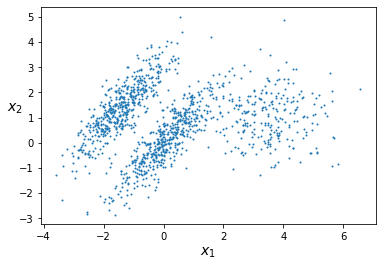

In [5]:
plot_clusters(X)

如同上週所提到，K-means在上述之資料集之分群容易訓練不佳。

現在遇到的問題是： $\textbf{有沒有簡單的模型能夠fit 圓形及橢圓形的資料?}$

答：有的，高斯模型

In [6]:
from scipy.stats import multivariate_normal

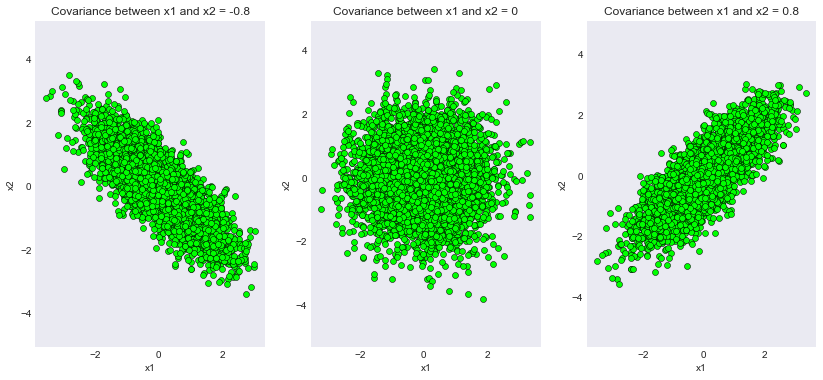

In [7]:
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize']=14,6
 
# Initializing the random seed
random_seed=1000
 
# List containing the variance
# covariance values
cov_val = [-0.8, 0, 0.8]
 
# Setting mean of the distributino to
# be at (0,0)
mean = np.array([0,0])
 
# Iterating over different covariance
# values
for idx, val in enumerate(cov_val):
    plt.subplot(1,3,idx+1)
     
    # Initializing the covariance matrix
    cov = np.array([[1, val], [val, 1]])
     
    # Generating a Gaussian bivariate distribution
    # with given mean and covariance matrix
    distr = multivariate_normal(cov = cov, mean = mean,
                                seed = random_seed)
     
    # Generating 5000 samples out of the
    # distribution
    data = distr.rvs(size = 5000)
     
    # Plotting the generated samples
    plt.plot(data[:,0],data[:,1], 'o', c='lime',
             markeredgewidth = 0.5,
             markeredgecolor = 'black')
    plt.title(f'Covariance between x1 and x2 = {val}')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.axis('equal')
     
plt.show()

想法：既然高斯模型能處理圓形及橢圓形資料，那我們能拿來做分群嗎?

<a id='sec2'></a>
## GMM

<a id='sec2.1'></a>
### Theory

給定：<br>
$X \in N\times D$ : 資料集。N :資料筆數，D :特徵數量 <br>
$Z\in \{1,2,...,K\}$: 群組之變數。K : 設定之分群數量 <br>

假設：<br>
$Z \sim Multinomial(1;p_1,...,p_K)$ with $\sum\limits_{i=1}^{K}p_i = 1$. <br>
$X | Z=k \sim N(\mu_k,\sigma_k^2)$

$\Rightarrow$ $X$ is a mixture of Gaussian distributions.

假設的涵義：<br>
1. 群組為多項分配
2. 單看其中一個群組，群組內的資料分配為高斯分配

問題：如何用資料配適出模型? <br>
答：<br>
步驟1. 用MLE 估計參數$(p_k,\mu_k,\sigma_k^2)$, k=1,...,K. <br>
步驟2. 因為MLE 估計量為參數之函數，設定偏微分=0之同時會使得參數有所變動，彼此關聯糾纏不清。<br>
故使用E-M演算法做調整

推導之過程參考附檔：[*參考資料*](https://www.cs.toronto.edu/~rgrosse/csc321/mixture_models.pdf)。<br>
以下直接介紹模型

<a id='sec2.2'></a>
### Code

In [8]:
from sklearn.mixture import GaussianMixture

In [9]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42) #init_params = ‘kmeans’ (default)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

In [10]:
gm.weights_
#p_1,p_2,...,p_K

array([0.39025715, 0.40007391, 0.20966893])

In [11]:
gm.means_
# (x_1,x_2)在各個群組的平均值 shape = (群組數量,特徵數量)

array([[ 0.05131611,  0.07521837],
       [-1.40763156,  1.42708225],
       [ 3.39893794,  1.05928897]])

In [12]:
gm.covariances_
# (x_1,x_2)在各個群組的共變異數矩陣 shape = (群組數量,特徵數量,特徵數量)

array([[[ 0.68799922,  0.79606357],
        [ 0.79606357,  1.21236106]],

       [[ 0.63479409,  0.72970799],
        [ 0.72970799,  1.1610351 ]],

       [[ 1.14833585, -0.03256179],
        [-0.03256179,  0.95490931]]])

# 需要注意的地方

使用E-M演算法跟K-means一樣都可能收斂到不好的解，所以為了避免此情況可以調整`n_init`參數(預設是1)，讓模型多訓練幾次，並且保留最佳解(模型會自動保留最佳解)

In [13]:
gm.converged_ #看模型在跑了n_init次數之後有沒有收斂

True

In [14]:
gm.n_iter_ #實際上只需進行幾次迭代訓練

4

# 使用模型來預測

In [15]:
gm.predict(X) #得出每個資料點的分群 (硬性分群)

array([0, 0, 1, ..., 2, 2, 2], dtype=int64)

In [16]:
Z = gm.predict(X)

In [17]:
Z

array([0, 0, 1, ..., 2, 2, 2], dtype=int64)

In [18]:
gm.predict_proba(X) #不得出分群，只得出可能落在各自分群的機率 (軟性分群)

array([[9.76741808e-01, 6.78581203e-07, 2.32575136e-02],
       [9.82832955e-01, 6.76173663e-04, 1.64908714e-02],
       [7.46494398e-05, 9.99923327e-01, 2.02398402e-06],
       ...,
       [4.26050456e-07, 2.15512941e-26, 9.99999574e-01],
       [5.04987704e-16, 1.48083217e-41, 1.00000000e+00],
       [2.24602826e-15, 8.11457779e-41, 1.00000000e+00]])

In [19]:
X1 = []
X2 = []
X3 = []

先把分群結果各自記錄起來

In [20]:
for i in range(len(Z)):
    if Z[i] == 1:
        X1.append(X[i])
    elif Z[i] == 2:
        X2.append(X[i])
    else:
        X3.append(X[i])

# 常態分配假設檢定

回顧高斯混合模型之假設第二點：

$X | Z=k \sim N(\mu_k,\sigma_k^2)$

我們來檢驗分群之結果是否真的為常態分配之假設。<br>
對於單變數常態分配之檢驗的方法主要分為：

1. 畫圖 e.g. Q-Q plot, 直方圖等等
2. 經驗分布函數法(empirical distribution function) e.g. Kolmogorov-Smirnov
3. 回歸與相關性法 e.g. Shapiro-Wilk
4. 動差法 (Moment Test) e.g. Jarque-Bera

所有scipy提供之檢驗方法如連結中之Statistical tests部分：[*參考資料*](https://docs.scipy.org/doc/scipy/reference/stats.html)

所有檢驗方法之相同處在於： **檢驗樣本分配跟常態分配差多少**

在$100*(1-\alpha)\%$ 信心水準之下<br>
$H_0$ : 樣本是常態分配 <br>
$H_1$ : 樣本不是常態分配

只要p-value小於 $\alpha$，則拒絕虛無假設，代表資料不是常態分配；<br>
反之，如果p-value大於 $\alpha$，則不拒絕虛無假設，可認定資料為常態分配。

一般常用到的檢驗法如上述，但是因為每個方法假設不同，適合的資料也不同，所以可能不同檢驗法出來的結果不一樣。

建議是去了解使用到的方法的假設，或是一次使用多個方法，如果結果一致就當作結論是可信的。

In [21]:
from scipy import stats

In [22]:
jarque_bera_test = stats.jarque_bera(X1)

In [23]:
jarque_bera_test

Jarque_beraResult(statistic=44.839150007874, pvalue=1.833589946542702e-10)

In [24]:
stats.jarque_bera(X2)

Jarque_beraResult(statistic=12.003724977002154, pvalue=0.0024741398257988045)

In [25]:
stats.jarque_bera(X3)

Jarque_beraResult(statistic=1.7252832132403266, pvalue=0.42204572969110776)

In [26]:
stats.shapiro(X1)

ShapiroResult(statistic=0.9702461361885071, pvalue=1.8514065335071411e-13)

In [27]:
stats.shapiro(X2) 

ShapiroResult(statistic=0.9874022603034973, pvalue=0.00027759894146583974)

In [28]:
stats.shapiro(X3)

ShapiroResult(statistic=0.9982047080993652, pvalue=0.37747058272361755)

可以發現只有第三個分類 (接近圓形)的資料有通過常態之檢驗，這是因為兩個常態分配的變數何在一起看並不一定是常態分配(主要是相關性的問題)

# 多元常態分配

注意到我們分群的結果是個**二維變數**，所以上面的J-B test跟S-W test都不滿足我們想要的結果。<br>
所以我們需要能夠檢驗多元常態分配的方法。

而檢驗的程式用到 `pingouin` 套件

In [29]:
from pingouin import multivariate_normality

這是對應到Henze-Zirkler multivariate normality test. <br>
跟單變數常態分配檢驗一樣<br>
在$100*(1-\alpha)\%$ 信心水準之下<br>
$H_0$ : 樣本是常態分配 <br>
$H_1$ : 樣本不是常態分配

In [30]:
multivariate_normality(X1, alpha=.05)

HZResults(hz=0.5106775340117936, pval=0.8474868471560542, normal=True)

In [31]:
multivariate_normality(X2, alpha=.05)

HZResults(hz=0.7405229691485358, pval=0.3029366030717905, normal=True)

In [32]:
multivariate_normality(X3, alpha=.05)

HZResults(hz=0.38058811041237467, pval=0.9791866546639815, normal=True)

三個分類結果都有符合多元常態分配的假設

# 畫出結果

In [19]:
from matplotlib.colors import LogNorm

In [22]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

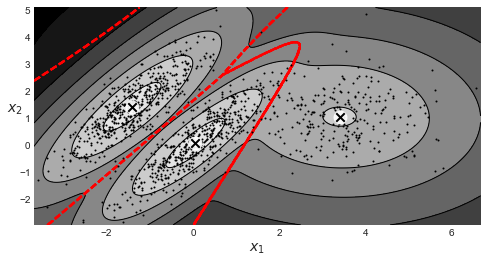

In [24]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()

# 選擇最佳的分群數量

使用AIC 跟 BIC來做判斷

In [27]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [28]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

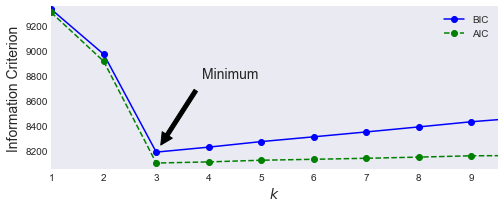

In [29]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

# 換不一樣的起始質心選取方法

跟K-means一樣我們可以用K-means ++ 當作起始質心的選取方法 (init_params = ‘k-means++’) <br>
(但是要注意scikit-learn版本要高於1.1)

In [35]:
import sklearn

In [36]:
sklearn.__version__

'1.0.2'

所以此方法有興趣的成員可以自行練習

# 延伸學習：Variational Bayesian Gaussian Mixture

如果覺得主觀設定分群數量很不科學，可以試試此方法

In [37]:
from sklearn.mixture import BayesianGaussianMixture

In [38]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

In [39]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

模型自動學出「**只有3個群組有權重**」，多設的那7個群組權重為0

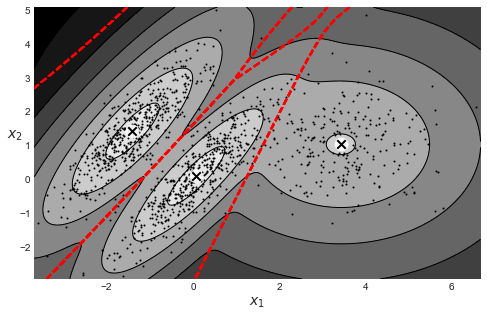

In [40]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()